In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

EDA:

In [84]:
trades = pd.read_parquet('md/trades.parquet')
ticker = pd.read_parquet('md/ticker.parquet')
book = pd.read_parquet('md/book.parquet')
target = pd.read_parquet('md/target.parquet')

In [85]:
target['target'].value_counts()

 0    18049007
 1     9806614
-1     9709959
Name: target, dtype: int64

In [86]:
book.rename(columns={'local_timestamp': 'local_ts'}, inplace=True)
target['local_ts'] = pd.to_datetime(target['local_ts'])
book['local_ts'] = pd.to_datetime(book['local_ts'])
trades['local_ts'] = pd.to_datetime(trades['local_ts'])

In [87]:
local_ts_col = book['local_ts']
book.drop(local_ts_col[sorted(local_ts_col) != local_ts_col].index, inplace=True)
## the target is sorted by local_ts

In [88]:
df = pd.merge_asof(left=book, right=target, on='local_ts')
df = pd.merge_asof(left=df, right=trades, on='local_ts')

df['book_mid_price'] = (df['asks[0].price'] + df['bids[0].price']) / 2

In [89]:
df

,exchange,symbol,timestamp,local_ts,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,...,bids[24].price,bids[24].amount,target,seq,remote_ts,remote_ts2,price,amount,side,book_mid_price
0,binance-futures,BTCUSDT,1679443200138000000,2023-03-22 00:00:00.485131264,28091.2,16.183,28091.1,0.001,28091.3,7.874,...,28087.6,0.002,0,3467110989,1679443200001,1679443199996,28091.1,0.179,S,28091.15
1,binance-futures,BTCUSDT,1679443202062000000,2023-03-22 00:00:02.065465600,28090.9,6.995,28090.8,0.002,28091.0,0.735,...,28087.4,0.001,0,3467110991,1679443202030,1679443201081,28091.0,0.003,S,28090.85
2,binance-futures,BTCUSDT,1679443202688000000,2023-03-22 00:00:02.691394048,28090.9,7.005,28090.8,0.002,28091.0,0.735,...,28087.4,0.001,0,3467110991,1679443202030,1679443201081,28091.0,0.003,S,28090.85
3,binance-futures,BTCUSDT,1679443202809000000,2023-03-22 00:00:02.812150528,28090.9,6.885,28090.8,0.002,28091.0,0.735,...,28087.4,0.001,0,3467110992,1679443202777,1679443201569,28090.9,0.547,B,28090.85
4,binance-futures,BTCUSDT,1679443203186000000,2023-03-22 00:00:03.188767744,28090.9,6.885,28090.8,0.002,28091.0,0.735,...,28087.4,0.001,0,3467110992,1679443202777,1679443201569,28090.9,0.547,B,28090.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403192,binance-futures,BTCUSDT,1679702399829000000,2023-03-24 23:59:59.832702464,27439.0,3.012,27438.9,6.973,27439.3,0.001,...,27435.6,0.022,0,3487666435,1679702399812,1679702399808,27438.9,0.041,S,27438.95
6403193,binance-futures,BTCUSDT,1679702399861000000,2023-03-24 23:59:59.864089088,27439.0,3.012,27438.9,6.973,27439.3,0.001,...,27435.6,0.022,0,3487666435,1679702399812,1679702399808,27438.9,0.041,S,27438.95
6403194,binance-futures,BTCUSDT,1679702399893000000,2023-03-24 23:59:59.896144640,27439.0,3.012,27438.9,6.973,27439.3,0.001,...,27435.6,0.022,0,3487666435,1679702399812,1679702399808,27438.9,0.041,S,27438.95
6403195,binance-futures,BTCUSDT,1679702399925000000,2023-03-24 23:59:59.928461568,27439.0,3.012,27438.9,6.982,27439.3,0.001,...,27435.6,0.022,0,3487666435,1679702399812,1679702399808,27438.9,0.041,S,27438.95


# Feature engineering
 ## Technical analysis:

In [90]:
def accumulation_distribution_line(md, window: int):
    """
        Technical Analysis feature
        
        md: market data (book, trades or merged md)
        window: 10, 20, 50, 100
    """
    close_price = md['book_mid_price'].iloc[window:]
    close_price = pd.concat([pd.Series([np.nan for i in range(window)]), close_price])
    lowest_price = md['book_mid_price'].rolling(window).min()
    highest_price = md['book_mid_price'].rolling(window).max()

    money_flow_multiplier = ((close_price - lowest_price) - (highest_price - close_price)) / (highest_price - lowest_price)
    ADL = money_flow_multiplier.cumsum()

    print(f"Nan values for window={window} --- {ADL.isnull().sum()}, before ffilling")

    ## Working with Nan values
    # naive:
    # ADL.fillna(0, inplace=True)
    # better variation is ffill -- forward filling (taking last non nan element)
    ADL.ffill(inplace=True)
    return ADL

In [91]:
ADL = accumulation_distribution_line(df, window=100)

Nan values for window=100 --- 1487901, before ffilling


In [92]:
def average_directional_index(md, window: int):
    """
        Technical Analysis feature
        https://medium.com/codex/algorithmic-trading-with-average-directional-index-in-python-2b5a20ecf06a
        
        md: market data (book, trades or merged md)
        window: 14
    """
        
    L = md['price'].rolling(window).min()
    H = md['price'].rolling(window).max()
    CL = md['price']
    
    plus_dm = H.diff()
    minus_dm = L.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(H - L)
    tr2 = pd.DataFrame(abs(H - CL.shift(1)))
    tr3 = pd.DataFrame(abs(L - CL.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join = 'inner').max(axis = 1)
    atr = tr.rolling(window).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))
    DX = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    ADX = ((DX.shift(1) * (window - 1)) + DX) / window
    ADX_smooth = ADX.ewm(alpha=1/window).mean()

    print(f"Nan values for window={window} --- {ADX_smooth.isnull().sum()}, before ffilling")
    ADX.ffill(inplace=True)
    return ADX_smooth

In [93]:
ADX = average_directional_index(df, 14)

Nan values for window=14 --- 27, before ffilling


In [94]:
def chande_momentum_oscillator(md, window: int, scalar: int = 100):
    """
        Technical Analysis feature
        
        md: market data (book, trades or merged md)
        window: 10, 20, 50, 100
        scalar: 100 for cmo range [-100, 100]; generally [-scalar, +scalar]
    """
    mom = df['price'].diff()
    positive = mom.copy().clip(lower=0)
    negative = mom.copy().clip(upper=0).abs()

    positive = positive.rolling(window).sum()
    negative = negative.rolling(window).sum()

    CMO = scalar * (positive - negative) / (positive + negative)
    
    print(f"Nan values for window={window} --- {CMO.isnull().sum()}, before ffilling")
    CMO.ffill(inplace=True)
    return CMO

In [95]:
CMO = chande_momentum_oscillator(df, 100)

Nan values for window=100 --- 726, before ffilling


In [96]:
def momentum(md):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        
        md: market data (book, trades or merged md)
    """
    MOM = md['price'].diff()
    return MOM

In [97]:
def rate_of_change(md, window: int = 12):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        window: size=12 
    """
    ROC = (md['price'] - md['price'].shift(window)) / md['price'].shift(window) * 100
    return ROC

In [98]:
ROC = rate_of_change(df, 12)

Stochastic Relative Strength Index -- Triple Exponential Moving Average (TEMA)

In [99]:
def ema(md, span: float, adjust: bool, close: pd.Series = None):
    """
        Technical Analysis feature
        
        md: market data (book, trades or merged md)
        span: Specify decay in terms of span
        adjust: see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    """
    CL = close if close is not None else md['price']
    EMA = CL.ewm(span=span, adjust=adjust).mean()
    return EMA

In [100]:
def triple_exponential_moving_average(md, close: pd.Series, span: int, window: int = 12):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        https://www.investopedia.com/terms/t/triple-exponential-moving-average.asp
        
        md: market data (book, trades or merged md)
        window: size=12 
    """
    CL = close if close is not None else md['price']
    ema1 = ema(df, span=span, adjust=True, close=CL)
    ema2 = ema(df, span=span, adjust=True, close=ema1)
    ema3 = ema(df, span=span, adjust=True, close=ema2)
    TEMA = 3 * (ema1 - ema2) + ema3
    return TEMA

In [101]:
def linear_regression_line(md, window_learning=10, window_forecasting=1):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        window_learning:
        window_forecasting:
    """
        
    X_train = md['price'].copy()
    y_train = md['price'].shift(-window_forecasting)
    
    X_mean = X_train.rolling(window_learning).mean()
    y_mean = y_train.rolling(window_learning).mean()
    
    XminusX_mean = X_train - X_mean
    YminusY_mean = y_train - y_mean
    
    b1 = (XminusX_mean * YminusY_mean).rolling(window_learning).sum() / (XminusX_mean * XminusX_mean).rolling(window_learning).sum()#ddd
    b1[b1 == np.inf] = np.nan
    b1[b1 == -np.inf] = np.nan
    b0 = y_mean - b1 * X_mean
    
    b1.ffill(inplace=True)
    b0.ffill(inplace=True)

    return b0, b1

In [102]:
LRL1, LRL2 = linear_regression_line(df, window_learning=10, window_forecasting=1)

In [103]:
def realized_volatility(md, depth: int):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        depth: order book depth
    """
    delta = pd.DataFrame({'delta': md['price'].diff()})
    delta.fillna(0, inplace=True)
    delta = delta * delta
    RV = delta.rolling(depth).sum()
    RV.fillna(0, inplace=True)
    
    return RV

In [104]:
RV = realized_volatility(df, 10)

In [105]:
def realized_kernel(md, horizon: int = 7, window: int = 1000, kernel = 'Bartlett'):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        horizon:
        window:
        kernel:
    """

    def k(x, kernel):
        if kernel == 'Bartlett':
            return 1 - x

    returns = md['price'].diff()
    shifts_covs = pd.DataFrame(index=md.index)
    for i in range(1, horizon + 1):
        shifts_covs[f'h={i}'] = returns.rolling(window).cov(returns.shift(i)) * window * k(x=(i - 1) / horizon, kernel=kernel)
    for i in range(-horizon, 0):
        shifts_covs[f'h={i}'] = returns.rolling(window).cov(returns.shift(i)) * window * k(x=(-i + 1) / horizon, kernel=kernel)
    
    variance = md['price'].rolling(window).var()
    RK = variance + shifts_covs.sum(axis=1)
    return RK

In [106]:
RK = realized_kernel(df)

In [107]:
### prerequisite to jump_variation
import math

def realized_bipower_variation(md, depth: int):
    """
        Technical Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        depth: order book depth
    """
    delta = pd.DataFrame({'delta' : md['book_mid_price'].diff()})
    delta.fillna(0, inplace=True)
    shifted = delta.shift(1)
    shifted.fillna(0, inplace=True)
    another_delta = delta * shifted

    RBV = another_delta.rolling(depth).sum()
    RBV.fillna(0, inplace=True)
    RBV = RBV.apply(lambda x: x * math.pi * 0.5)
    return RBV

In [108]:
RBV10 = realized_bipower_variation(df, 10)

In [109]:
def jump_variation(md, depth: int = 10):
    JV = realized_volatility(md, depth) - realized_bipower_variation(md, depth)
    return JV

In [110]:
JV = jump_variation(df) 

In [111]:
JV['delta']

0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
           ... 
6403192    0.03
6403193    0.02
6403194    0.02
6403195    0.01
6403196    0.01
Name: delta, Length: 6403197, dtype: float64

## Quantitative indicators:

In [112]:
def order_book_imbalance(md, depth: int):
    """
        Quantitative Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        depth: order book depth
    """
    ask_volumes = md[[f'asks[{i}].amount' for i in range(depth)]]
    bid_volumes = md[[f'bids[{i}].amount' for i in range(depth)]]
    
    mean_ask_volume = ask_volumes.mean(axis=1)
    mean_bid_volume = bid_volumes.mean(axis=1)    
    OBI = (mean_bid_volume - mean_ask_volume) / (mean_ask_volume + mean_bid_volume)

    return OBI

In [113]:
OBI = order_book_imbalance(df, 10)

In [114]:
def autocorrelation(md, window: int = 10, lag: int = 10):
    """
        Quantitative Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        window:
        lag: 
    """
    shifted = md['price'].shift(lag)
    
    std1 = md['price'].rolling(window).std()
    std2 = shifted.rolling(window).std()
    cov = (shifted * md['price']).rolling(window).mean() - shifted.rolling(window).mean() * md['price'].rolling(window).mean()
    correlation = cov / (std1 * std2)

    correlation[correlation == np.inf] = np.nan
    correlation.ffill(inplace = True)
    
    return correlation

In [115]:
AUTOCORR = autocorrelation(df)

In [116]:
def partial_correlation(md, window=1000, lag=10):
    """
        Quantitative Analysis feature
        paper: Mid-price prediction based on machine learning methods with technical and quantitative indicators
        Adamantios Ntakaris
        
        md: market data (book, trades or merged md)
        window:
        lag: 
    """
    Prices = md['price'].copy()
    answ = pd.DataFrame(index=md.index)
    
    for i in range(1, lag + 1):
        shifted = Prices.shift(i)
        correlation = Prices.rolling(window).corr(shifted)
        answ[f'{i} coeff'] = correlation
        Prices -= correlation * shifted
    
    return answ

In [117]:
PARTCORR = partial_correlation(df)['1 coeff']

## Fitting:

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier

In [119]:
df_ = pd.DataFrame({
                    ## technical 
                    'ADL10': accumulation_distribution_line(df, 10),
                    'ADL35': accumulation_distribution_line(df, 35),
                    'ADL100': accumulation_distribution_line(df, 100),

                    'ADX14': average_directional_index(df, 14),
                    'ADX25': average_directional_index(df, 25),
                    'ADX55': average_directional_index(df, 55),

                    'CMO100': chande_momentum_oscillator(df, 100),
                    'CMO50': chande_momentum_oscillator(df, 50),
                    'CMO20': chande_momentum_oscillator(df, 20),

                    'MOM': momentum(df),

                    'ROC12': rate_of_change(df, 12),
                    'ROC25': rate_of_change(df, 25),
                    'ROC50': rate_of_change(df, 50),

                    'TEMA': triple_exponential_moving_average(df, close=None, span=10, window=12),

                    'LRL': linear_regression_line(df)[0],

                    'RV5': realized_volatility(df, 5)['delta'],
                    'RV10': realized_volatility(df, 10)['delta'],
                    'RV15': realized_volatility(df, 15)['delta'],

                    'RK': realized_kernel(df),

                    'RBV5': realized_bipower_variation(df, 5)['delta'],
                    'RBV10': realized_bipower_variation(df, 10)['delta'],
                    'RBV15': realized_bipower_variation(df, 15)['delta'],

                    'JV': jump_variation(df)['delta'],

                    ## quantitative
                    'OBI5': order_book_imbalance(df, 5),
                    'OBI10': order_book_imbalance(df, 10),
                    'OBI15': order_book_imbalance(df, 15),

                    'AUTOCORR': autocorrelation(df),

                    'PARTCORR': partial_correlation(df)['1 coeff']
                    }
                    )


Nan values for window=10 --- 4761055, before ffilling
Nan values for window=35 --- 3125735, before ffilling
Nan values for window=100 --- 1487901, before ffilling
Nan values for window=14 --- 27, before ffilling
Nan values for window=25 --- 49, before ffilling
Nan values for window=55 --- 131, before ffilling
Nan values for window=100 --- 726, before ffilling
Nan values for window=50 --- 18255, before ffilling
Nan values for window=20 --- 317186, before ffilling


In [120]:
df_.fillna(0.0, inplace=True)

In [121]:
df_

,ADL10,ADL35,ADL100,ADX14,ADX25,ADX55,CMO100,CMO50,CMO20,MOM,...,RK,RBV5,RBV10,RBV15,JV,OBI5,OBI10,OBI15,AUTOCORR,PARTCORR
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,-0.999370,-0.997879,-0.997250,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.1,...,0.000000,0.0,0.0,0.0,0.00,-0.998349,-0.998308,-0.989797,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,-0.998350,-0.998308,-0.989799,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.1,...,0.000000,0.0,0.0,0.0,0.00,-0.998344,-0.998303,-0.989769,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,-0.998344,-0.998303,-0.989797,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6403192,3082.285217,-548.06032,-7924.505564,10.474071,99.799522,87.381437,-44.827586,0.0,0.0,0.0,...,7.169415,0.0,0.0,0.0,0.03,0.394771,0.200312,0.199433,-0.149787,0.996925
6403193,3082.285217,-548.06032,-7925.505564,9.893653,99.799690,87.354616,-44.827586,0.0,0.0,0.0,...,7.286733,0.0,0.0,0.0,0.02,0.394771,0.200312,0.199433,-0.149787,0.996928
6403194,3082.285217,-548.06032,-7926.505564,9.354694,99.799852,87.328284,-44.827586,0.0,0.0,0.0,...,7.293018,0.0,0.0,0.0,0.02,0.394771,0.204931,0.204040,-0.149831,0.996931
6403195,3082.285217,-548.06032,-7927.505564,8.854232,99.800007,87.302430,-44.827586,0.0,0.0,0.0,...,7.271210,0.0,0.0,0.0,0.01,0.395312,0.205440,0.208319,-0.179755,0.996934


In [122]:
y = df['target']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(df_, y, test_size = 0.3, random_state = 42, shuffle=False)

In [124]:
# train_dataset = cb.Pool(X_train, y_train)
# catboost_class = CatBoostClassifier(logging_level='Verbose')
# catboost_class.fit(train_dataset)

In [125]:
## metric
import numpy as np
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

In [126]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [127]:
hgb = HistGradientBoostingClassifier()
hgb.fit(X_train, y_train)
y_pred_test = hgb.predict(X_test)
metric(y_test, y_pred_test)

/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


-53.34429328459853

# Postprocessing

## Feature importance on Catboost 

In [79]:
train_dataset = cb.Pool(X_train, y_train)
catboost_class = CatBoostClassifier(logging_level='Verbose')
catboost_class.fit(train_dataset)
y_pred_test = catboost_class.predict(X_test)
metric(y_pred_test, y_test)

Learning rate set to 0.121493
0:	learn: 1.0428452	total: 1.06s	remaining: 17m 43s
1:	learn: 1.0016514	total: 1.89s	remaining: 15m 45s
2:	learn: 0.9705601	total: 2.68s	remaining: 14m 51s
3:	learn: 0.9466680	total: 3.41s	remaining: 14m 10s
4:	learn: 0.9276978	total: 4.23s	remaining: 14m 1s
5:	learn: 0.9127157	total: 5.21s	remaining: 14m 22s
6:	learn: 0.9004640	total: 6.12s	remaining: 14m 28s
7:	learn: 0.8906618	total: 7.04s	remaining: 14m 32s
8:	learn: 0.8826608	total: 8.11s	remaining: 14m 53s
9:	learn: 0.8761221	total: 8.86s	remaining: 14m 37s
10:	learn: 0.8707632	total: 10.1s	remaining: 15m 9s
11:	learn: 0.8663265	total: 10.8s	remaining: 14m 52s
12:	learn: 0.8624213	total: 11.8s	remaining: 14m 57s
13:	learn: 0.8592817	total: 12.7s	remaining: 14m 57s
14:	learn: 0.8565494	total: 13.7s	remaining: 15m 2s
15:	learn: 0.8543945	total: 14.6s	remaining: 14m 58s
16:	learn: 0.8524931	total: 15.5s	remaining: 14m 56s
17:	learn: 0.8507811	total: 16.4s	remaining: 14m 52s
18:	learn: 0.8493239	total: 1

-67.50931980553098

Text(0.5, 1.0, 'Feature Importance')

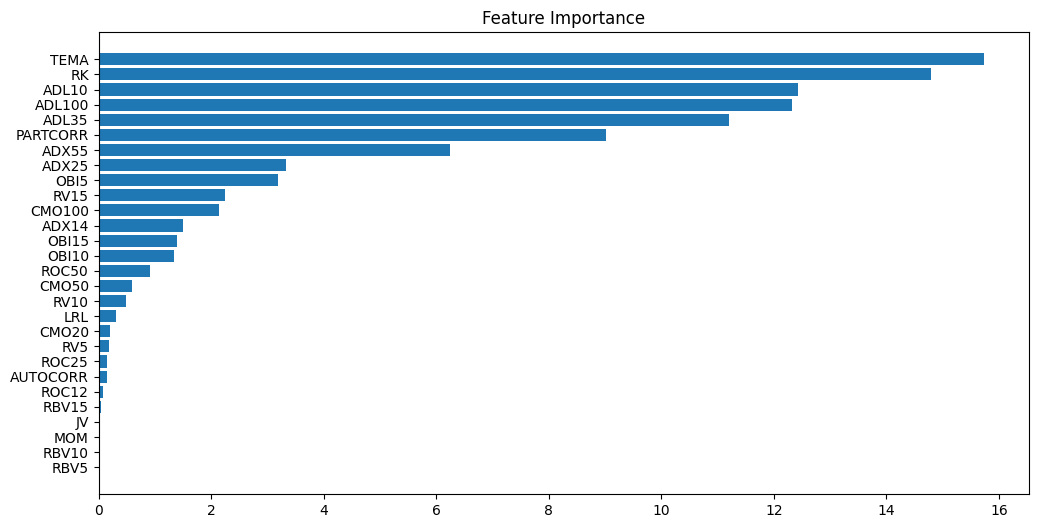

In [80]:
feature_importance = catboost_class.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


## Hyperparam tuning

In [128]:
from sklearn.model_selection import GridSearchCV

In [129]:
params = {'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [4, 5],
          'min_samples_leaf': [4, 5]}
hgb = HistGradientBoostingClassifier()
grid_hgb = GridSearchCV(hgb, params, cv=2)
grid_hgb.fit(X_train, y_train)
y_pred_test = grid_hgb.predict(X_test)

/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/hayk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeW

In [132]:
grid_hgb.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 4}

In [130]:
metric(y_test, y_pred_test)

21.722379422311793